In [ ]:
import os
import numpy as np
import pandas as pd
import re

folder_path = r"C:\Users\mason\Work\CMEC_SandwichPanel\Data\Raw\bending_stiffness"
contents = os.listdir(folder_path)

pattern = re.compile(r'bending_(\d+\.?\d*)_(\d+\.?\d*)_(\d+\.?\d*)\.csv$')
data = []

for filename in contents:
    if not filename.endswith('.csv'):
        continue
    file_path = os.path.join(folder_path, filename)
    match = pattern.search(filename)
    if not match:
        print(f"Match not found for {filename}")

    try:
            # The third group in the regex match corresponds to the Angle
            angle = float(match.group(3)) 
            df_content = pd.read_csv(file_path)
            
            # Use the first row for all values
            first_row = df_content.iloc[0] 
            
            thickness = first_row['Thickness']
            height = first_row['Height']
            stiffness = first_row['Bending_Stiffness']

            data.append({
                'Thickness': thickness,
                'Height': height,
                'Angle (deg)': angle,
                'Bending_Stiffness': stiffness
            })
    except ValueError as e:
        print(f"Error parsing numerical data in {filename}: {e}. Skipping.")
        break
    except KeyError as e:
        print(f"Error: Missing expected column {e} in file {filename}. Skipping.")
        break
df = pd.DataFrame(data)
df.to_csv('processed_bending_stiffness.csv', index=False)

In [ ]:
# Remove duplicates
# initial_count = len(df)
# df = df.drop_duplicates()
# removed_count = initial_count - len(df)
# if removed_count > 0:
#     print(f"Removed {removed_count} duplicate row(s) from the dataset.")

X = df[['Thickness', 'Height', 'Angle (deg)']]
y = df['Bending_Stiffness']
print(f"Y Max - Y Min: {y.max() - y.min()}")

Y Max - Y Min: 26763.854898876994


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining the Multi-Layer Perceptron (MLP) model...")
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,  # Use 10% of training for validation
    n_iter_no_change=20,  # Stop if no improvement for 20 iterations
    random_state=42,
)

mlp.fit(X_train_scaled, y_train)

print("Training complete.")

y_pred = mlp.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\n--- Model Evaluation on Test Data ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.4f} (Closer to 1.0 is better)")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Demonstrate a single prediction
new_data = pd.DataFrame([{
    'Thickness': 3.5,
    'Height': 30.0,
    'Angle (deg)': 45.0
}])

# You must scale new data using the same scaler fitted on the training data
new_data_scaled = scaler.transform(new_data)
predicted_stiffness = mlp.predict(new_data_scaled)

print(f"\nExample Prediction (Input: {new_data.iloc[0].to_dict()}):")
print(f"Predicted Bending Stiffness: {predicted_stiffness[0]:.2f}")


Training the Multi-Layer Perceptron (MLP) model...
Training complete.

--- Model Evaluation on Test Data ---
Mean Squared Error (MSE): 1056166.03
R-squared (R2) Score: 0.9705 (Closer to 1.0 is better)
Mean Absolute Error (MAE): 714.06
Mean Absolute Percentage Error (MAPE): 165.96%

Example Prediction (Input: {'Thickness': 3.5, 'Height': 30.0, 'Angle (deg)': 45.0}):
Predicted Bending Stiffness: 981.86


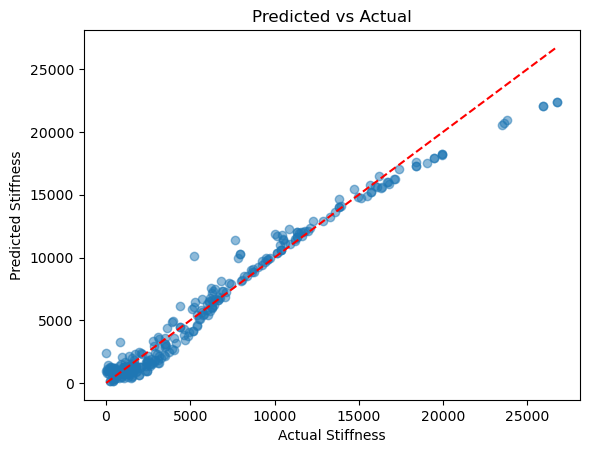

In [43]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Stiffness')
plt.ylabel('Predicted Stiffness')
plt.title('Predicted vs Actual')
plt.show()